<a href="https://colab.research.google.com/github/SamuReyes/practica_final_IAO/blob/clasificador/notebook_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = "simonbermejomendez"
os.environ['KAGGLE_KEY'] = "cda106a2f3240f78cfd62bb0ec8d66c3"

In [ ]:
!kaggle datasets download -d mahmoudima/mma-facial-expression

In [ ]:
!unzip /content/mma-facial-expression.zip

In [ ]:
!pip install keras-tuner -q

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Conv2D, MaxPooling2D, \
Rescaling, Lambda, Dropout
from keras import optimizers

from keras_tuner


import cv2

import matplotlib.pyplot as plt

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
img = image.load_img('/content/MMAFEDB/test/angry/10Exp0angry_actor_150.jpg')
plt.imshow(img)

In [ ]:
cv2.imread('/content/MMAFEDB/test/angry/10Exp0angry_actor_150.jpg').shape

#Dataset 
- link: https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory 

In [ ]:
training_set = tf.keras.utils.image_dataset_from_directory(
    '/content/MMAFEDB/train',
    #para obtenerlo en color: color_mode = "rgb"
    color_mode = 'grayscale',
    shuffle = False,
    batch_size = 32,
    image_size = (48,48),
    seed = 123
)

Found 92968 files belonging to 7 classes.


##Visualización de los datos

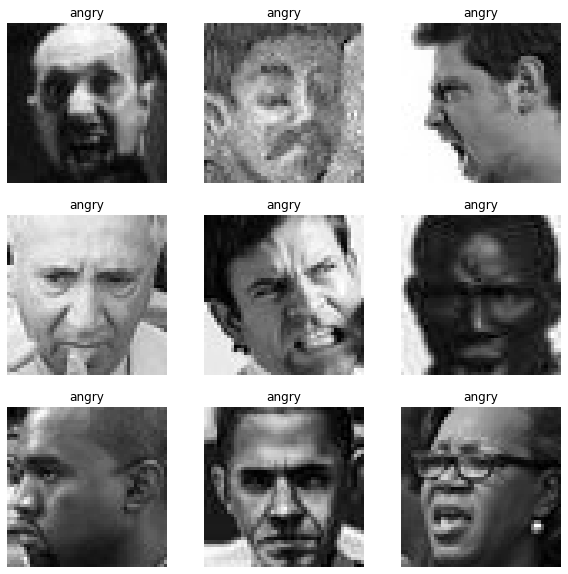

In [ ]:
class_names = training_set.class_names

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #Para obtenerlo en color eliminar : .reshape(48,48), cmap="gray"
    plt.imshow(images[i].numpy().astype("uint8").reshape(48,48), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")


#Rendimientos de memoria
- Dataset.cache: mantiene en cache las imagenes.
- Dataset.prefetch: superpone / carga del cache.

In [ ]:
#ni santa idea pero esto es para colab y la memoria :)
AUTOTUNE = tf.data.AUTOTUNE
#Guardamos en cache 1000 datos aleatorios. 
training_set = training_set.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

#Ejemplo de modelo
- Para construir el modelo link: https://www.tensorflow.org/tutorials/images/classification




In [ ]:
model = Sequential()
#Kernel_size => se puede tunear
kernel_size = 8
input_shape = (48,48, 3)

#Normalizamos los datos
model.add(Rescaling(1./255, input_shape=input_shape)),

#Capas de preprocesamiento
#model.add(Lambda(lambda: x: tf.image.rgb_to_grayscale(x)))

#Capa convolucional.
model.add(Conv2D(64, kernel_size=(kernel_size, kernel_size), padding="valid", strides=1, input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D())
#Capa de salida
model.add(Dense(7))
model.add(Activation('softmax'))


#Hypermodelo de Tuner

Datos: 
- Capas de preprocesamiento.https://www.tensorflow.org/guide/keras/preprocessing_layers 
https://www.tensorflow.org/tutorials/images/data_augmentation 
- Kernel_shape
- '# Capas convolucionales. https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
- '# Capas Ocultas Densas (Normales)
- Activacion ? Relu vs SoftRelu ?
- Dropout

In [ ]:
def build_model(hp):
    model = Sequential()
    #input shape ?? 
    inputs = keras.Input(shape=(48, 48, 1))

    #Normalize data
    model.add(Rescaling(1./255, input_shape=input_shape)),

    # Tune of num of layers of the CNN .
    for i in range(hp.Int("cnn_layers", 1, 3)):

      # Tune of num of filters, options [32,64,96,128]
      model.add(Conv2D(hp.Int(f"filters_{i}", 32, 128, step=32),
                 kernel_size=(8, 8),
                 activation="relu"
                 ))
      model.add(MaxPooling2D())
      model.add(Flatten())

    #Dropout tune.
    if hp.Boolean("dropout"):
      model.add(Dropout(0.5))

    #Output layer
    model.add(Dense(units=7, activation="softmax"))
    
    # Compile the model.
    #TODO: revisar loss function. esa o mse
    model.compile(
        loss="sparse_categorical_crossentropy", metrics=["accuracy", "mse"], optimizer="adam",
    )
    return model